In [1]:
############################################################################################################
########################################    FUNCTIONS AND MODEL   ##########################################
############################################################################################################

########################### USED AS A SHARED PART BETWEEN TRAINING AND TESTING  ############################

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes

import random
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import sys, os, time
import numpy as np

img_size = 256
channels = 3
test_batch_percentage = 0.1
examples_to_show = 4

# Parameters
logs_path = 'MODEL/log_stats_my_faceswap_deconvolutional'
batch_size = 16
learning_rate = 0.001
training_epochs = 200000
display_step = 500

def get_image_paths( directory ):
    return [ x.path for x in os.scandir( directory ) if x.name.endswith(".jpg") or x.name.endswith(".png") ]

# TIMING CONTROL
def print_time():
    elapsed_time = time.time() - start_time
    mins = int(elapsed_time / 60)
    secs = elapsed_time - (mins * 60)
    print("Accumulative time: %02d:%02d" % (mins, int(secs % 60)))
    
########################################    TF IMAGE PREPROCESS   ##########################################

def get_tf_images(path):
    images = get_image_paths( path )

    # create a partition vector
    partitions = [0] * len(images)
    partitions[:int(len(images) * test_batch_percentage)] = [1] * int(len(images) * test_batch_percentage)
    random.shuffle(partitions)

    # convert string into tensors
    all_images = ops.convert_to_tensor(images, dtype=dtypes.string)

    # partition our data into a test and train set according to our partition vector
    train_images, test_images = tf.dynamic_partition(all_images, partitions, 2)

    # create input queues
    train_input_queue = tf.train.slice_input_producer([train_images], shuffle=True)
    test_input_queue = tf.train.slice_input_producer([test_images], shuffle=True)

    # process path and string tensor into an image and a label
    file_content = tf.read_file(train_input_queue[0])
    train_image = tf.image.decode_jpeg(file_content, channels=channels)
    file_content = tf.read_file(test_input_queue[0])
    test_image = tf.image.decode_jpeg(file_content, channels=channels)

    # define tensor shape
    train_image.set_shape([img_size, img_size, channels])
    test_image.set_shape([img_size, img_size, channels])

    # collect batches of images before processing
    train_image_batch = tf.train.batch([train_image], batch_size=batch_size)
    test_image_batch = tf.train.batch([test_image], batch_size=int(len(images) * test_batch_percentage))
    
    return train_image_batch, test_image_batch

###########################################    MODELS   ####################################################

n1 = 16
n2 = 32
n3 = 64
    
def encoder(_X, _keepprob, name, reuse=True):
    with tf.device("/gpu:0"):
        with tf.variable_scope(name) as scope:
            if reuse:
                scope.reuse_variables()
                
            _W = {
                'ce1': tf.Variable(tf.random_normal([5, 5, channels, n1], stddev=0.1)),
                'ce2': tf.Variable(tf.random_normal([5, 5, n1, n2], stddev=0.1)),
                'ce3': tf.Variable(tf.random_normal([5, 5, n2, n3], stddev=0.1))
            }
            
            _b = {
                'be1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
                'be2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
                'be3': tf.Variable(tf.random_normal([n3], stddev=0.1))
            }

            _ce1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_X, _W['ce1'], strides=[1,2,2,1], padding='SAME'), _b['be1']))
            _ce1 = tf.nn.dropout(_ce1, _keepprob)
            _ce2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce1, _W['ce2'], strides=[1,2,2,1], padding='SAME'), _b['be2']))
            _ce2 = tf.nn.dropout(_ce2, _keepprob)
            _ce3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce2, _W['ce3'], strides=[1,2,2,1], padding='SAME'), _b['be3']))
            _ce3 = tf.nn.dropout(_ce3, _keepprob)
    return _ce3

def decoder(encoder_input, _X, _keepprob, name, reuse=False):
    with tf.device("/gpu:0"):
        with tf.variable_scope(name) as scope:
            if reuse:
                scope.reuse_variables()
                
            _W = {
                'cd3': tf.Variable(tf.random_normal([5, 5, n2, n3], stddev=0.1)),
                'cd2': tf.Variable(tf.random_normal([5, 5, n1, n2], stddev=0.1)),
                'cd1': tf.Variable(tf.random_normal([5, 5, channels, n1], stddev=0.1))
            }
            
            _b = {
                'bd3': tf.Variable(tf.random_normal([n2], stddev=0.1)),
                'bd2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
                'bd1': tf.Variable(tf.random_normal([channels], stddev=0.1))
            }

            _cd3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(encoder_input, _W['cd3'],\
                                                               tf.stack([_X, 64, 64, n2]),\
                                                               strides=[1,2,2,1], padding='SAME'), _b['bd3']))
            _cd3 = tf.nn.dropout(_cd3, _keepprob)
            _cd2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd3, _W['cd2'],\
                                                               tf.stack([_X, 128, 128, n1]),\
                                                               strides=[1,2,2,1], padding='SAME'), _b['bd2']))
            _cd2 = tf.nn.dropout(_cd2, _keepprob)
            _cd1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd2, _W['cd1'],\
                                                               tf.stack([_X, 256, 256, 3]),\
                                                               strides=[1,2,2,1], padding='SAME'), _b['bd1']))
            _cd1 = tf.nn.dropout(_cd1, _keepprob)
            _out = _cd1
    return _out

###################################    COST FUNCTION AND OPTIMIZER   #######################################

def cost_func(pred, name):
    with tf.device("/gpu:0"):
        # Prediction have a sigmoid so it's limited to 0-1 and usual image are between 0-255 each pixel
        cost = tf.reduce_sum(tf.abs(tf.subtract(pred, tf.divide(Y, 255))))
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

        # SUMMARIES
        tf.summary.scalar(name, cost)
        summary_op = tf.summary.merge_all()
        return cost, optimizer
    
###################################    SHOW TRAIN RESULTS & SAVE   #########################################

show_batch_A = True
show_images = True
def display_results(sess, epoch):
    with tf.device("/gpu:0"):
        global show_batch_A, show_images
        print("Epoch %02d/%02d average cost: %.4f"
               % (epoch, training_epochs, sess.run(cost_A, \
                                                   feed_dict={X: batch_images,\
                                                              Y: batch_images, dropout_keep_prob: 1})))
        print_time()
        if (show_images):
            if (show_batch_A):
                test_images = sess.run(test_image_batch_A)
                recon = sess.run(pred_A, feed_dict={X: test_images, dropout_keep_prob: 1})
            else:
                test_images = sess.run(test_image_batch_B)
                recon = sess.run(pred_B, feed_dict={X: test_images, dropout_keep_prob: 1})
        #                 test_images_noisy = test_images + 0.3 * np.random.randn(examples_to_show, img_size * img_size * channels)

            fig, axs = plt.subplots(2, examples_to_show, figsize=(30, 16))
            for example_i in range(examples_to_show):
                axs[0, example_i].imshow(test_images[example_i])
                axs[1, example_i].imshow(recon[example_i])

            plt.show()
            show_batch_A = not show_batch_A

        # SAVE IT
        save_path_encoder = saver_encoder.save(sess, 'MODEL/encoder/saved_encoder', global_step=epoch)
        save_path_decoder_A = saver_decoder_A.save(sess, 'MODEL/decoder_A/saved_decoder_A', global_step=epoch)
        save_path_decoder_B = saver_decoder_B.save(sess, 'MODEL/decoder_B/saved_decoder_B', global_step=epoch)
        print("Encoder saved to %s" % save_path_encoder)
        print("Decoder A saved to %s" % save_path_decoder_A)
        print("Decoder B saved to %s" % save_path_decoder_B)
        


Epoch 00/200000 average cost: 825044.5625
Accumulative time: 00:02


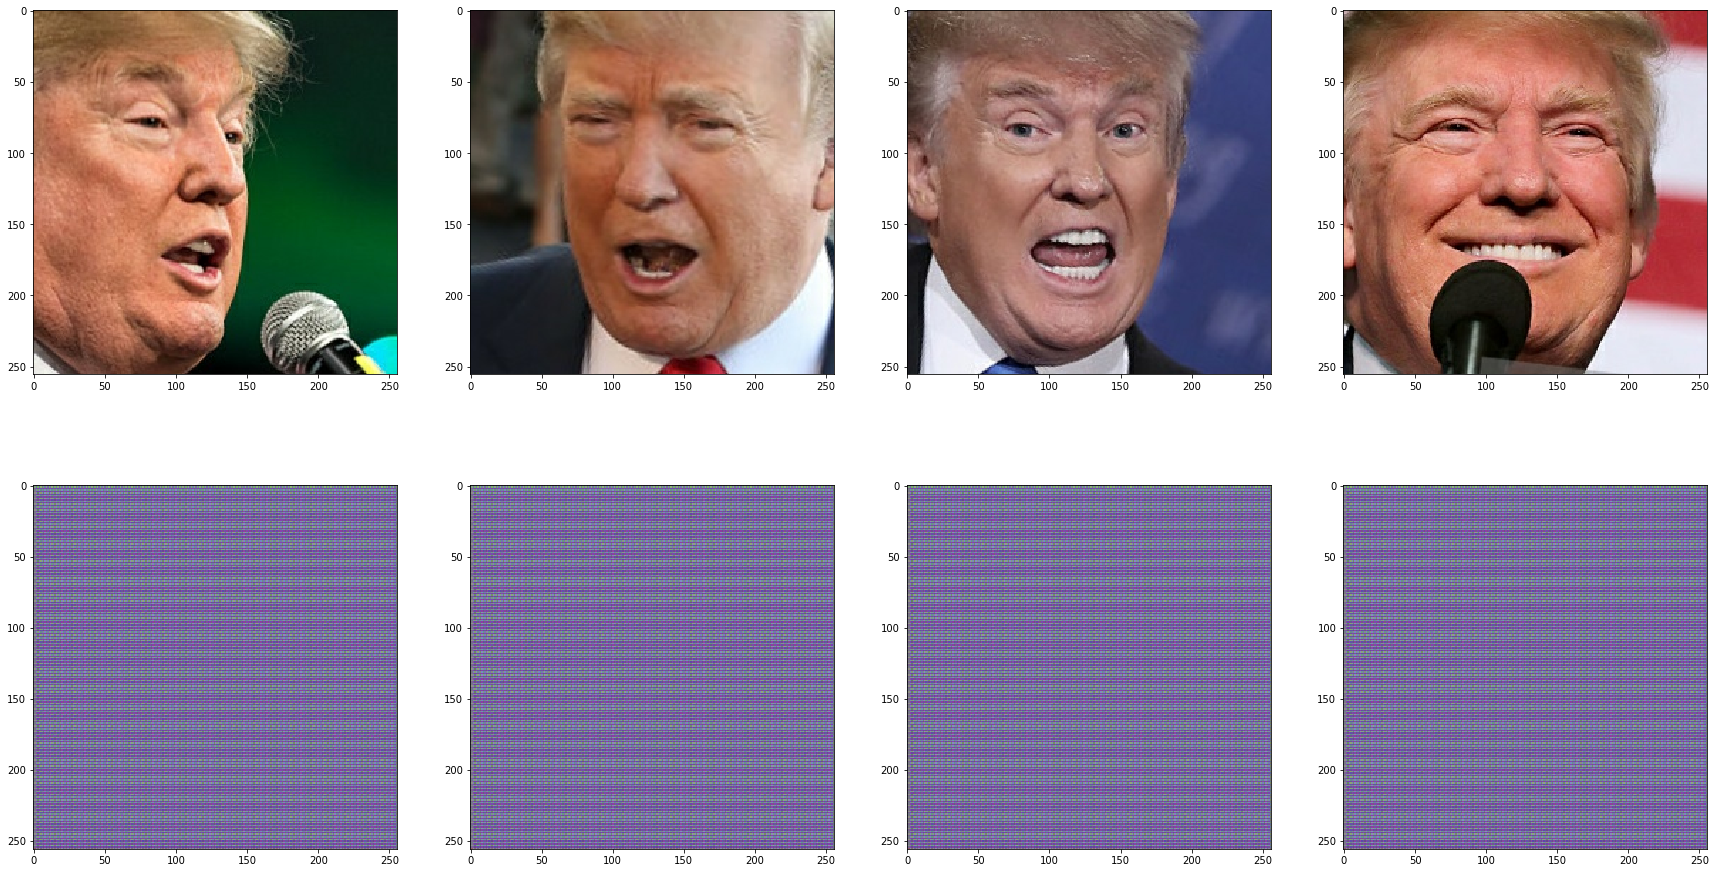

Encoder saved to MODEL/encoder/saved_encoder-0
Decoder A saved to MODEL/decoder_A/saved_decoder_A-0
Decoder B saved to MODEL/decoder_B/saved_decoder_B-0
Epoch 500/200000 average cost: 704145.4375
Accumulative time: 01:27


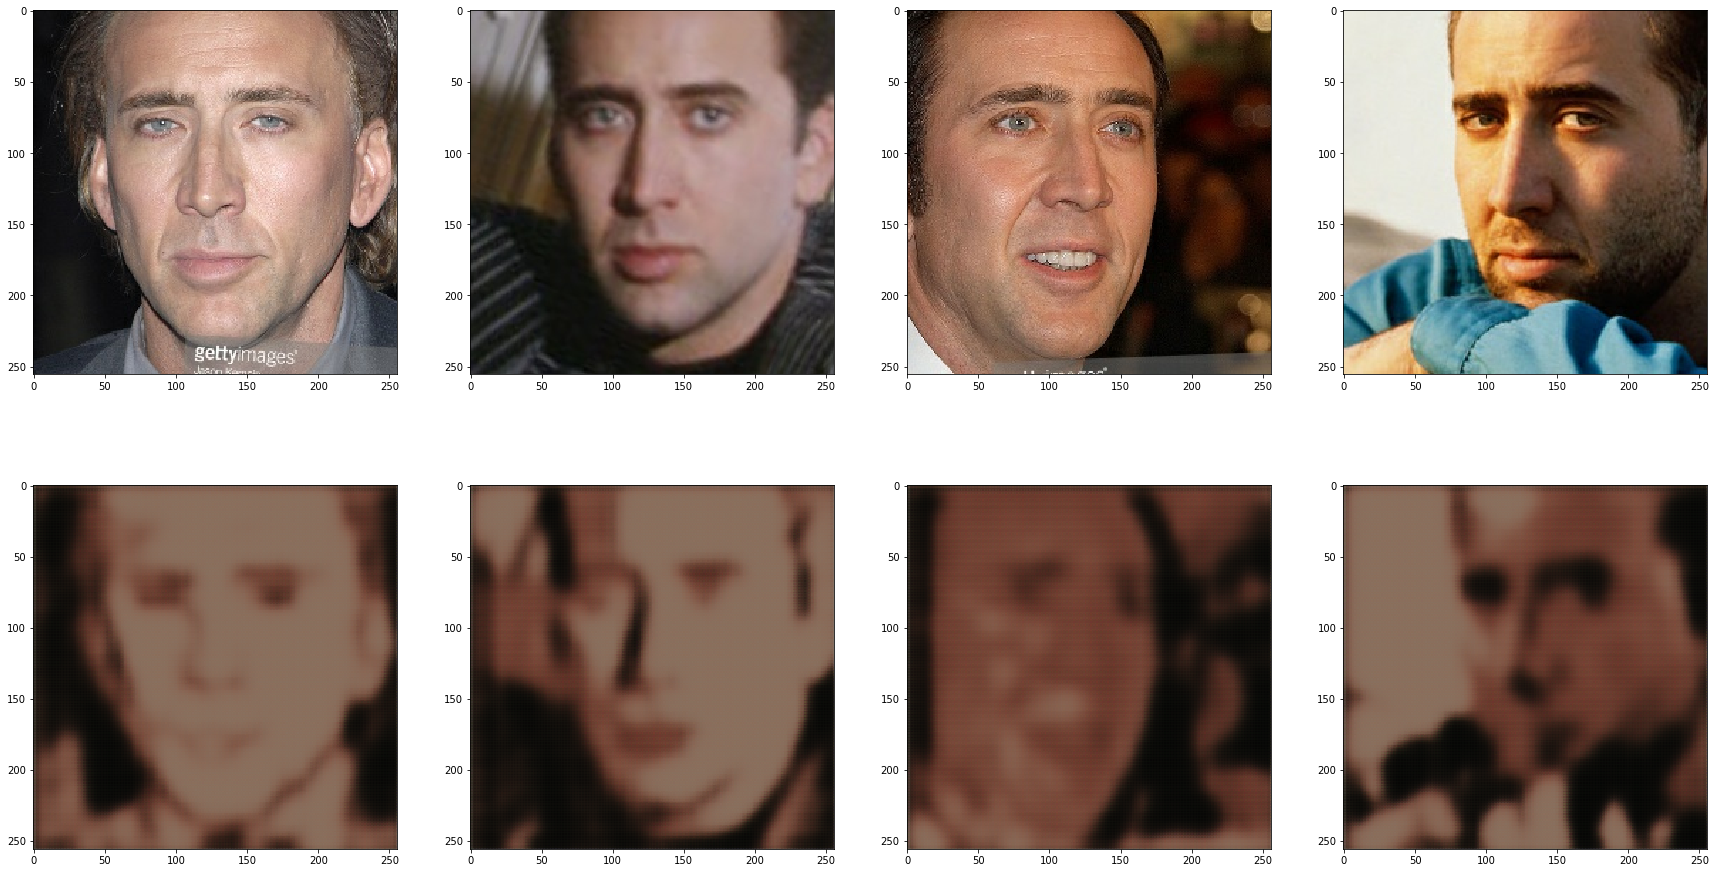

Encoder saved to MODEL/encoder/saved_encoder-500
Decoder A saved to MODEL/decoder_A/saved_decoder_A-500
Decoder B saved to MODEL/decoder_B/saved_decoder_B-500
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_2/input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer_2/input_producer, input_producer_2/input_producer/RandomShuffle)]]


KeyboardInterrupt: 

In [2]:
############################################################################################################
#########################################    DEFINITION & TRAIN   ##########################################
############################################################################################################

############# USE: Restart Kernel + Run first Cell (FUNCTIONS & MODEL) + Then run this cell ################

#############################################    DEFINITION   ##############################################
with tf.device("/gpu:0"):
    
    # TF IMAGE PREPROCESS
    train_image_batch_A, test_image_batch_A = get_tf_images("DATASET/trump/")
    train_image_batch_B, test_image_batch_B = get_tf_images("DATASET/cage/")
    
    # INPUTS AND DESIRED OUTPUT
    X = tf.placeholder(tf.float32, [None, img_size, img_size, channels],name="input")
    Y = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name="prediction")
    dropout_keep_prob = tf.placeholder(tf.float32)

    # MODEL
    enc = encoder (X, dropout_keep_prob, 'encoder', True)
    pred_A = decoder(enc, tf.shape(X)[0], dropout_keep_prob, 'decoder_A', False)
    pred_B = decoder(enc, tf.shape(X)[0], dropout_keep_prob, 'decoder_B', False)
    
    # COST & OPTIMIZERS
    cost_A, optimizer_A = cost_func(pred_A, "cost_A")
    cost_B, optimizer_B = cost_func(pred_B, "cost_B")
    
#############################################    TRAIN   ###################################################
    
    config = tf.ConfigProto(allow_soft_placement = True, log_device_placement=True)
    with tf.Session(config = config) as sess:
        start_time = time.time()
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        
        t_vars = tf.trainable_variables()
        encoder_vars = [var for var in t_vars if 'encoder' in var.name]
        decoder_A_vars = [var for var in t_vars if 'decoder_A' in var.name]
        decoder_B_vars = [var for var in t_vars if 'decoder_B' in var.name]
        saver_encoder = tf.train.Saver(encoder_vars)
        saver_decoder_A = tf.train.Saver(decoder_A_vars)
        saver_decoder_B = tf.train.Saver(decoder_B_vars)
        
        for epoch in range(training_epochs):
            # TRAIN ENCONDER + DECODER_A WITH BATCH_A
            batch_images = sess.run(train_image_batch_A)
            feeds = {X: batch_images, Y: batch_images, dropout_keep_prob: 0.7}
            sess.run(optimizer_A, feed_dict=feeds)
        
            # TRAIN ENCONDER + DECODER_B WITH BATCH_B
            batch_images = sess.run(train_image_batch_B)
            feeds = {X: batch_images, Y: batch_images, dropout_keep_prob: 0.7}
            sess.run(optimizer_B, feed_dict=feeds)
            
            if epoch % display_step == 0:
                display_results(sess, epoch)
                sys.stdout.flush()
        
        coord.request_stop()
        coord.join(threads)
        sess.close()
        print("Finished in %s seconds" % (time.time() - start_time))

./DATAS/encoder/saved_encoder-199500
INFO:tensorflow:Restoring parameters from ./DATAS/encoder/saved_encoder-199500
./DATAS/decoder_A/saved_decoder_A-199500
INFO:tensorflow:Restoring parameters from ./DATAS/decoder_A/saved_decoder_A-199500


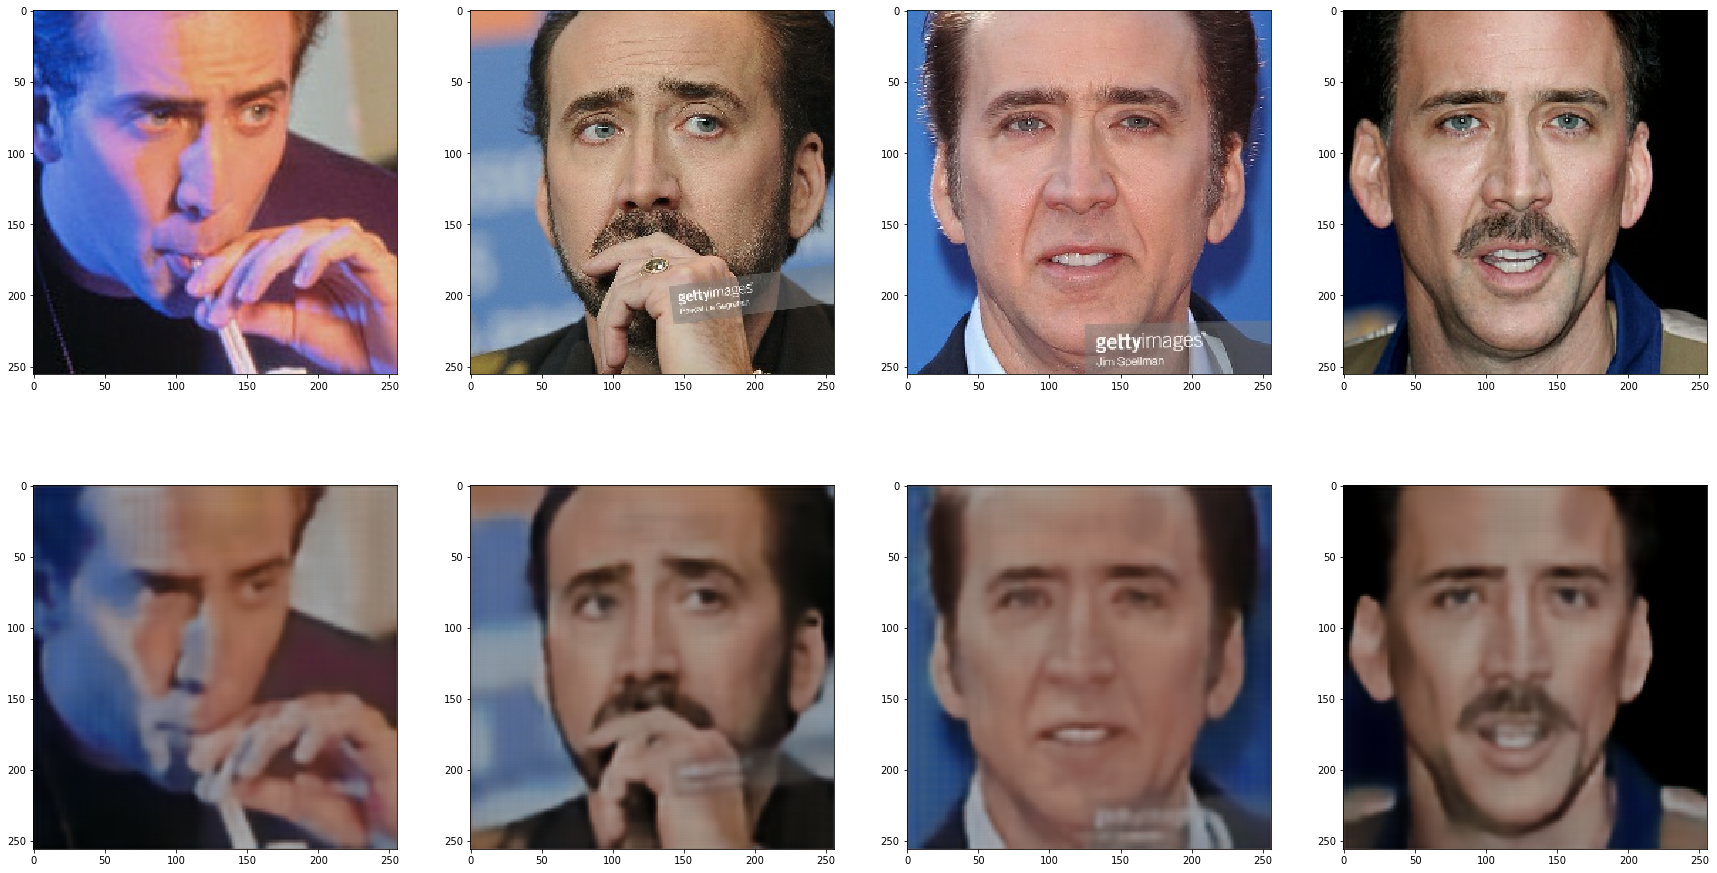

Finished in 4.138444423675537 seconds


In [2]:
############################################################################################################
############################################    TESTING   ##################################################
############################################################################################################

############# USE: Restart Kernel + Run first Cell (FUNCTIONS & MODEL) + Then run this cell ################

###########################################    EXECUTION   #################################################

decoder_selected = 'decoder_A'
# decoder_selected = 'decoder_B'

with tf.device("/gpu:0"):
    # TF IMAGE PREPROCESS
#     train_image_batch, test_image_batch = get_tf_images("DATASET/trump/")
    train_image_batch, test_image_batch = get_tf_images("DATASET/cage/")

    # INPUTS AND DESIRED OUTPUT
    X = tf.placeholder(tf.float32, [None, img_size, img_size, channels],name="input")
    Y = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name="prediction")
    dropout_keep_prob = tf.placeholder(tf.float32)

    # MODEL
    enc = encoder (X, dropout_keep_prob, 'encoder', True)
    pred = decoder(enc, tf.shape(X)[0], dropout_keep_prob, decoder_selected, False)

    config = tf.ConfigProto(allow_soft_placement = True, log_device_placement=True)
    with tf.Session(config = config) as sess:
        start_time = time.time()
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        t_vars = tf.trainable_variables()

        # LOAD ENCODER
        encoder_vars = [var for var in t_vars if 'encoder' in var.name]
        saver_encoder = tf.train.Saver(encoder_vars)
        ckpt = tf.train.latest_checkpoint('./MODEL/encoder/')
        print (ckpt)
        saver_encoder.restore(sess, ckpt)
        
        # LOAD DECODER
        decoder_vars = [var for var in t_vars if decoder_selected in var.name]
        saver_decoder = tf.train.Saver(decoder_vars)
        ckpt = tf.train.latest_checkpoint('./DATAS/'+decoder_selected+'/')
        print (ckpt)
        saver_decoder.restore(sess, ckpt)
        
        test_images = sess.run(test_image_batch)
        recon = sess.run(pred, feed_dict={X: test_images, dropout_keep_prob: 1})
        
        fig, axs = plt.subplots(2, examples_to_show, figsize=(30, 16))
        for example_i in range(examples_to_show):
            axs[0, example_i].imshow(test_images[example_i])
            axs[1, example_i].imshow(recon[example_i])

        plt.show()
        
        coord.request_stop()
        coord.join(threads)
        sess.close()
        print("Finished in %s seconds" % (time.time() - start_time))